# Analyse fréquentielle intégratrice

## Activité de transfert - 21 juillet 2022

préparée par :
- Duy Anh Alexandre
- Gabriel Gobeil
- Jonathan Jalbert

## Partie 3 : Analyse fréquentielle des simulations hydroclimatiques

L'objectif de cette partie est d'introduire les fonctions pour l'analyse fréquentielle des débits simulés de l'ensemble des simulations hydroclimatiques pour un tronçon de la rivière Chaudière. 

En particulier, les éléments suivants seront couvert :
- Prétraitement des données et sélection des membres 

- Modèle hiérarchique pour les maximas simulés

- Intervalles de confiance

- Figures diagnostiques

- Niveaux de retour

####  Table des matières
1. [Chargement des librairies et des fonctions utiles](#preparation)
2. [Chargement des données](#data)
    1. [Chargement des simulations hydroclimatiques](#data_loading)
    2. [Sélection des simulations hydroclimatiques](#data_selection)
4. [Modélisation bayésienne des maxima annuels simulés](#modelisation)
    1. [Modèle stationnaire](#mstat)
    2. [Modèle non stationnaire](#mnstat)
5. [Sélection de modèle](#selection)
5. [Enregistrement du modèle](#enregistrement)

---
# 1. Chargement des librairies et des fonctions utiles <a name="preparation"></a>

In [1]:
# Chargement des librairies
using CSV, DataFrames, Dates, NetCDF
using Distributions, Extremes, LinearAlgebra, Mamba, Random, Statistics
using Gadfly
using ProgressMeter, StatsBase

using Test

using ErrorsInVariablesExtremes

In [2]:
include("3-utils.jl")
include("3-hierarchicalbayesmodel.jl")
include("3-hierarchicalbayeseva.jl");

---
# 2. Chargement des données <a name="data"></a>

## 2.1 Chargement des simulations hydroclimatiques <a name="data_loading"></a>

#### Description des données

Les données se trouvent dans le fichier ```A2020_Simulation_Hydroclimatique_QMA_SLSO00003.nc``` qui contient 1080 simulations de débits produites par le modèle HYDROTEL en utilisant 6 configurations pour 180 simulations climatiques provenant de différents couples GCM-RCM de 1956 à 2100 (145 ans).

#### Chargement des données

In [3]:
filename = "../0-Data/0-Simulations/A2020_Simulation_Hydroclimatique_QMA_SLSO00003.nc"
data = load_discharge_simulations(filename)
first(data,1)

1×7 DataFrame
 Row │ Ensemble  GCM     RCM     Member  Scenario  Years                       ⋯
     │ String    String  String  String  String    Array…                      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ CM5       A10     XXX     R41     RCP45     [1956, 1957, 1958, 1959, 19 ⋯
                                                               2 columns omitted

## 2.2. Sélection des simulations hydroclimatiques <a name="data_selection"></a>

#### Exemple 1 : Simulations hydroclimatiques produites avec les simulations climatiques de l'ensemble ClimEx

Avec la fonction ```filter```, on peut sélectionner les lignes pour lesquelles l'ensemble correspond à ClimEx (CMX) :

In [4]:
climex_data = filter(row -> row[:Ensemble] == "CMX", data)

300×7 DataFrame
 Row │ Ensemble  GCM     RCM     Member  Scenario  Years                       ⋯
     │ String    String  String  String  String    Array…                      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ CMX       CE2     CO1     KDA     RCP85     [1956, 1957, 1958, 1959, 19 ⋯
   2 │ CMX       CE2     CO1     KDB     RCP85     [1956, 1957, 1958, 1959, 19
   3 │ CMX       CE2     CO1     KDC     RCP85     [1956, 1957, 1958, 1959, 19
   4 │ CMX       CE2     CO1     KDD     RCP85     [1956, 1957, 1958, 1959, 19
   5 │ CMX       CE2     CO1     KDE     RCP85     [1956, 1957, 1958, 1959, 19 ⋯
   6 │ CMX       CE2     CO1     KDF     RCP85     [1956, 1957, 1958, 1959, 19
   7 │ CMX       CE2     CO1     KDG     RCP85     [1956, 1957, 1958, 1959, 19
   8 │ CMX       CE2     CO1     KDH     RCP85     [1956, 1957, 1958, 1959, 19
   9 │ CMX       CE2     CO1     KDI     RCP85     [1956, 1957, 1958, 1959, 19 ⋯
  10 │ CMX       CE2     CO1     KDJ     RCP85     [1956, 1957, 1958, 1959, 19
  11 │ CMX       CE2     CO1     KDK     RCP85     [1956, 1957, 1958, 1959, 19
  ⋮  │    ⋮        ⋮       ⋮       ⋮        ⋮                      ⋮           ⋱
 291 │ CMX       CE2     CO1     KEO     RCP85     [1956, 1957, 1958, 1959, 19
 292 │ CMX       CE2     CO1     KEP     RCP85     [1956, 1957, 1958, 1959, 19 ⋯
 293 │ CMX       CE2     CO1     KEQ     RCP85     [1956, 1957, 1958, 1959, 19
 294 │ CMX       CE2     CO1     KER     RCP85     [1956, 1957, 1958, 1959, 19
 295 │ CMX       CE2     CO1     KES     RCP85     [1956, 1957, 1958, 1959, 19
 296 │ CMX       CE2     CO1     KET     RCP85     [1956, 1957, 1958, 1959, 19 ⋯
 297 │ CMX       CE2     CO1     KEU     RCP85     [1956, 1957, 1958, 1959, 19
 298 │ CMX       CE2     CO1     KEV     RCP85     [1956, 1957, 1958, 1959, 19
 299 │ CMX       CE2     CO1     KEW     RCP85     [1956, 1957, 1958, 1959, 19
 300 │ CMX       CE2     CO1     KEX     RCP85     [1956, 1957, 1958, 1959, 19 ⋯
                                                  2 columns and 279 rows omitted

Ici, comme l'ensemble ClimEx comporte 50 membres et qu'on a 6 configurations du modèle hydrologique, on obtient 300 simulations hydroclimatiques.

In [5]:
size(climex_data)

(300, 7)

#### Exemple 2 : Simulations hydroclimatiques produites avec les simulations climatiques du GCM de l'IPSL (IAL)

Avec la fonction ```filter```, on peut sélectionner les lignes pour lesquelles le GCM correspond à l'IPSL (IAL) :

In [6]:
ipsl_data = filter(row -> row.GCM == "IAL" && row.RCM == "XXX", data)

48×7 DataFrame
 Row │ Ensemble  GCM     RCM     Member  Scenario  Years                       ⋯
     │ String    String  String  String  String    Array…                      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ CM5       IAL     XXX     R41     RCP45     [1956, 1957, 1958, 1959, 19 ⋯
   2 │ CM5       IAL     XXX     R42     RCP45     [1956, 1957, 1958, 1959, 19
   3 │ CM5       IAL     XXX     R43     RCP45     [1956, 1957, 1958, 1959, 19
   4 │ CM5       IAL     XXX     R44     RCP45     [1956, 1957, 1958, 1959, 19
   5 │ CM5       IAL     XXX     R81     RCP85     [1956, 1957, 1958, 1959, 19 ⋯
   6 │ CM5       IAL     XXX     R82     RCP85     [1956, 1957, 1958, 1959, 19
   7 │ CM5       IAL     XXX     R83     RCP85     [1956, 1957, 1958, 1959, 19
   8 │ CM5       IAL     XXX     R84     RCP85     [1956, 1957, 1958, 1959, 19
   9 │ CM5       IAL     XXX     R41     RCP45     [1956, 1957, 1958, 1959, 19 ⋯
  10 │ CM5       IAL     XXX     R42     RCP45     [1956, 1957, 1958, 1959, 19
  11 │ CM5       IAL     XXX     R43     RCP45     [1956, 1957, 1958, 1959, 19
  ⋮  │    ⋮        ⋮       ⋮       ⋮        ⋮                      ⋮           ⋱
  39 │ CM5       IAL     XXX     R83     RCP85     [1956, 1957, 1958, 1959, 19
  40 │ CM5       IAL     XXX     R84     RCP85     [1956, 1957, 1958, 1959, 19 ⋯
  41 │ CM5       IAL     XXX     R41     RCP45     [1956, 1957, 1958, 1959, 19
  42 │ CM5       IAL     XXX     R42     RCP45     [1956, 1957, 1958, 1959, 19
  43 │ CM5       IAL     XXX     R43     RCP45     [1956, 1957, 1958, 1959, 19
  44 │ CM5       IAL     XXX     R44     RCP45     [1956, 1957, 1958, 1959, 19 ⋯
  45 │ CM5       IAL     XXX     R81     RCP85     [1956, 1957, 1958, 1959, 19
  46 │ CM5       IAL     XXX     R82     RCP85     [1956, 1957, 1958, 1959, 19
  47 │ CM5       IAL     XXX     R83     RCP85     [1956, 1957, 1958, 1959, 19
  48 │ CM5       IAL     XXX     R84     RCP85     [1956, 1957, 1958, 1959, 19 ⋯
                                                   2 columns and 27 rows omitted

Ici, comme on a accès à 8 membres (4 pour le scénario RCP4.5 et 4 pour le scénario RCP8.5) et qu'on a 6 configurations du modèle hydrologique, on obtient 48 simulations hydroclimatiques.

In [7]:
size(ipsl_data)

(48, 7)

---
# 3. Modélisation bayésienne des maxima annuels simulés <a name="modelisation"></a>


## 3.1 Modèle stationnaire  <a name="mstat"></a>

### 3.1.1 Définition du modèle

#### Couche des données

\begin{equation*}
    f_{(X_{ij}|\mu_i, \phi_i, \xi_i)}(x_{ij}) = \mathcal{G}EV(x_{ij} \mid \mu_i, \sigma_i, \xi_i)
\end{equation*}

où $x_{ij}$ correspond au maximum annuel de l'année j du membre i.

#### Couche latente

La loi normale est utilisée pour modéliser la dépendance des paramètres de la loi GEV entre les différents membres. Par exemple, pour le paramètre de localisation, on suppose que les paramètres de localisation de chacun des membres  proviennent tous d'une même distribution :

\begin{equation*}
    f_{(\mu_i| \nu_0, \tau_0)} = \mathcal{N}(\mu_{i} \mid \nu_0, \tau_0)
\end{equation*}

#### Loi *a priori*

Une loi *a priori* vague est utilisée pour les paramèetres de la couche latente. Par exemple pour $(\nu_0, \tau_0)$, la loi *a priori* est la suivante :

\begin{equation*}
    f_{(\nu_0, \tau_0)}(\nu_0, \tau_0) \propto \mathcal{I}nverse\mathcal{G}amma(0.01, 0.01)
\end{equation*}


#### Structure `HierarchicalBayesModel`

On encapsule les données et la loi *a priori* des hyperparamètres dans la structure `HierarchicalBayesModel` :

In [8]:
# Préparation de la liste de modèles BlockMaxima avec les données
M₁ = BlockMaxima[]
for i in 1:size(ipsl_data,1)
    push!(M₁, BlockMaxima(Variable("y", ipsl_data[i, :Discharges])))
end

# Préparation du modèle hiérachique 
model1 = HierarchicalBayesModel(M₁, [Flat(), InverseGamma(0.01, 0.01)])

HierarchicalBayesModel
  data:		Vector{BlockMaxima}[48]
  hyperparameters: ν, τ
  hyperprior: [Flat(), InverseGamma{Float64}(
invd: Gamma{Float64}(α=0.01, θ=100.0)
θ: 0.01
)
]


<div class="alert alert-block alert-info">
    <b>Note :</b> Actuellement, seule la loi <i>a priori</i> inverse-gamma pour τ est implémentée. Les paramètres peuvent néanmoins être modifiés. 

### 3.1.2 Génération d'un échantillon de la loi *a posteriori* par MCMC

La fonction `fitbayes` permet de générer un échantillon de la loi *a posteriori* des paramètres du modèle bayésien défini précédement. 

La fonction prend en entrée une structure `HierarchicalBayesModel`.

In [9]:
fm1_std = fitbayes(model1)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


?? parameters acceptance rate

?? mean acceptance rate



HierarchicalBayesStdEVA
   model: HierarchicalBayesModel
   hyperparameters :
		Mamba.Chains
		Iterations :		10000:20000
		Thinning interval :	10
		Chains :		1
		Samples per chain :	1001
		Value :			Array{Float64, 3}[1001,6,1]
   fittedmodels :		Vector{BayesianEVA{BlockMaxima}}[48]
   scale :		Float64
   offset :		Float64



<div class="alert alert-block alert-info">
    <b>Note :</b> Par défault, une standardisation des données est effectuée pour l'ajustement du modèle. Les résultats de l'ajustement du modèle sont contenus dans la structure <code>HierarchicalBayesStdEVA</code> qui contient les paramètres ajustés standardisés ainsi que les valeurs d'échelle (<i>scale</i>) et de décallage (<i>offset</i>) pour la standardisation.

La fonction `transform` peut être utilisée pour obtenir le modèle ajusté avec les paramètres à l'échelle originale :

In [10]:
fm1 = transform(fm1_std)

HierarchicalBayesEVA
   model: HierarchicalBayesModel
   hyperparameters :
		Mamba.Chains
		Iterations :		10000:20000
		Thinning interval :	10
		Chains :		1
		Samples per chain :	1001
		Value :			Array{Float64, 3}[1001,6,1]
   fittedmodels :		Vector{BayesianEVA{BlockMaxima}}[48]



In [11]:
fm1.hyperparameters.names

6-element Vector{AbstractString}:
 "ν_μ"
 "ν_ϕ"
 "ν_ξ"
 "τ_μ"
 "τ_ϕ"
 "τ_ξ"

In [12]:
fm1.fittedmodels

48-element Vector{BayesianEVA{BlockMaxima}}:
 BayesianEVA
model :
	BlockMaxima
	data :		Vector{Float64}[145]
	location :	μ ~ 1
	logscale :	ϕ ~ 1
	shape :		ξ ~ 1

sim :
	Mamba.Chains
	Iterations :		1:1001
	Thinning interval :	1
	Chains :		1
	Samples per chain :	1001
	Value :			Array{Float64, 3}[1001,3,1]

 BayesianEVA
model :
	BlockMaxima
	data :		Vector{Float64}[145]
	location :	μ ~ 1
	logscale :	ϕ ~ 1
	shape :		ξ ~ 1

sim :
	Mamba.Chains
	Iterations :		1:1001
	Thinning interval :	1
	Chains :		1
	Samples per chain :	1001
	Value :			Array{Float64, 3}[1001,3,1]

 BayesianEVA
model :
	BlockMaxima
	data :		Vector{Float64}[145]
	location :	μ ~ 1
	logscale :	ϕ ~ 1
	shape :		ξ ~ 1

sim :
	Mamba.Chains
	Iterations :		1:1001
	Thinning interval :	1
	Chains :		1
	Samples per chain :	1001
	Value :			Array{Float64, 3}[1001,3,1]

 BayesianEVA
model :
	BlockMaxima
	data :		Vector{Float64}[145]
	location :	μ ~ 1
	logscale :	ϕ ~ 1
	shape :		ξ ~ 1

sim :
	Mamba.Chains
	Iterations :		1:1001
	Thinning int

### 3.1.3 Affichage de la trace des hyperparamètres

Permet de constater si l'algorithme MCMC a bien convergé. Permet aussi de voir l'échelle des différents paramètres de la loi GEV.

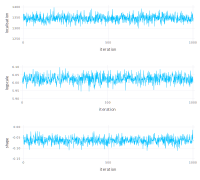

In [13]:
set_default_plot_size(20cm, 18cm)
p1 = plot(y = fm1.hyperparameters.value[:,1,:], Geom.line, 
        Guide.ylabel("localisation"), Guide.xlabel("iteration"), 
        Coord.cartesian(xmin=0, xmax=1000))

p2 = plot(y = fm1.hyperparameters.value[:,2,:], Geom.line, 
        Guide.ylabel("logscale"), Guide.xlabel("iteration"), 
        Coord.cartesian(xmin=0, xmax=1000))

p3 = plot(y = fm1.hyperparameters.value[:,3,:], Geom.line, 
        Guide.ylabel("shape"), Guide.xlabel("iteration"), 
        Coord.cartesian(xmin=0, xmax=1000))

vstack(p1, p2, p3)

### 3.1.4 Adéquation de la loi GEV aux membres de l'ensemble

#### Adéquation pour un membre

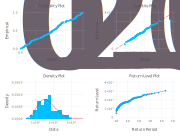

In [14]:
set_default_plot_size(18cm, 14cm)
diagnosticplots(fm1.fittedmodels[1])

### 3.1.5 Estimation des niveaux de retour

On estime les niveaux de retour avec l'ensemble des membres. On obtient alors un échantillon aléatoire de la loi prédictive du niveau de retour.

In [15]:
# Période de retour (en année)
T = 20

# Calcul de l'échantillon de la loi prédictive du niveau de retour
r = returnlevel(fm1, T)

ReturnLevel
returnperiod :	20
value :		Matrix{Float64}[48048]


<div class="alert alert-block alert-info">
    <b>Note :</b> Ici, on obtient 48048 valeurs de niveau de retour 20 ans puisqu'on a 1001 itérations MCMC et 48 simulations hydroclimatiques.

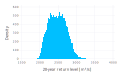

In [16]:
# Affichage de la loi prédictive

# Calcul du nombre de classes de l'histogramme
nbin = floor(Int64, sqrt(length(r.value)))

set_default_plot_size(12cm, 8cm)
plot(x=vec(r.value), Geom.histogram(bincount = nbin),
    Guide.xlabel(string(T,"-year return level [m³/s]")), Guide.ylabel("Density"))

## 3.2 Modèle non-stationnaire  <a name="mnstat"></a>

Le paramètre de localisation de la loi GEV est une fonction de la concentration de GES dans l'atmosphère.

\begin{equation*}
    f_{(X_{ij}|\mu_i, \phi_i, \xi_i)}(x_{ij}) = \mathcal{G}EV(x_{ij} \mid \mu_{ij}, \sigma_i, \xi_i)
\end{equation*}

avec

\begin{equation*}
    \mu_{ij} = \mu_{0i} + \mu_{1i} \times u_j
\end{equation*}

où

$u_{j}$ correspond à la concentration équivalente de CO₂ dans l'atmosphère.


### 3.2.1 Chargement des variables exlicatives

In [17]:
 # Chargement des données de CO₂
co2data = CSV.read("../0-Data/0-RCP/RCPdata.csv", DataFrame);

# Ajout de la covariable à la structure de données 
function get_co2(co2data, scenario, years)
    
    data = select(co2data, :Year, Symbol(scenario))
    filter!(row -> row.Year in years, data)
    
    return data[!, Symbol(scenario)]
end

ipsl_data[!, Symbol("CO₂")] = get_co2.(Ref(co2data), ipsl_data.Scenario, ipsl_data.Years);

### 3.2.2 Définition du modèle

In [18]:
# Préparation de la liste de modèles BlockMaxima avec les données
M₂ = BlockMaxima[]
for i in 1:size(ipsl_data,1)
    push!(M₂, BlockMaxima(Variable("y", ipsl_data[i, :Discharges]),
            locationcov = [Variable(ipsl_data[i,:Scenario], ipsl_data[i, :CO₂])]))
end

# Préparation du modèle hiérachique 
model2 = HierarchicalBayesModel(M₂, [Flat(), InverseGamma(0.01, 0.01)])

HierarchicalBayesModel
  data:		Vector{BlockMaxima}[48]
  hyperparameters: ν, τ
  hyperprior: [Flat(), InverseGamma{Float64}(
invd: Gamma{Float64}(α=0.01, θ=100.0)
θ: 0.01
)
]


### 3.2.3 Génération d'un échantillon de la loi *a posteriori* par MCMC

In [19]:
fm2_std = fitbayes(model2)
fm2 = transform(fm2_std)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


?? parameters acceptance rate

?? mean acceptance rate



HierarchicalBayesEVA
   model: HierarchicalBayesModel
   hyperparameters :
		Mamba.Chains
		Iterations :		10000:20000
		Thinning interval :	10
		Chains :		1
		Samples per chain :	1001
		Value :			Array{Float64, 3}[1001,8,1]
   fittedmodels :		Vector{BayesianEVA{BlockMaxima}}[48]



### 3.2.3 Affichage de la trace des hyperparamètres

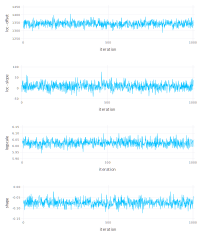

In [20]:
set_default_plot_size(20cm, 24cm)
p1 = plot(y = fm2.hyperparameters.value[:,1,:], Geom.line, 
        Guide.ylabel("loc - offset"), Guide.xlabel("iteration"), 
        Coord.cartesian(xmin=0, xmax=1000))

p2 = plot(y = fm2.hyperparameters.value[:,2,:], Geom.line, 
        Guide.ylabel("loc - slope"), Guide.xlabel("iteration"), 
        Coord.cartesian(xmin=0, xmax=1000))

p3 = plot(y = fm2.hyperparameters.value[:,3,:], Geom.line, 
        Guide.ylabel("logscale"), Guide.xlabel("iteration"), 
        Coord.cartesian(xmin=0, xmax=1000))

p4 = plot(y = fm2.hyperparameters.value[:,4,:], Geom.line, 
        Guide.ylabel("shape"), Guide.xlabel("iteration"), 
        Coord.cartesian(xmin=0, xmax=1000))

vstack(p1, p2, p3, p4)

### 3.2.4 Adéquation de la loi GEV aux membres de l'ensemble

On ne peut pas tracer de return level plot ici car le modèle est non stationnaire.

#### Adéquation pour un membre

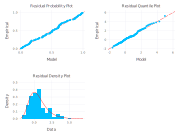

In [21]:
set_default_plot_size(18cm, 14cm)
diagnosticplots(fm2.fittedmodels[1])

### 3.2.5 Estimation des niveaux de retour effectifs

On estime les niveaux de retour effectifs avec l'ensemble des membres. On obtient alors un échantillon aléatoire de la loi prédictive des niveaux de retour pour chacune des années. 

In [22]:
# Période de retour
T = 20

# Calcul de la loi prédictive pour les niveaux de retour effectifs
r = returnlevel(fm2, T)

ReturnLevel
returnperiod :	20
value :		Matrix{Float64}[6966960]


<div class="alert alert-block alert-info">
    <b>Note :</b> Ici, on obtient 6966960 valeurs de niveau de retour 20 ans puisqu'on a, pour chacune des 145 années, 1001 itérations MCMC et 48 simulations hydroclimatiques.

Les intervalles de crédibilité sur la valeur du niveau de retour estimé peuvent être calculés avec la fonction `cint`. Ici, on calcule l'intervalle pour un niveau de confiance à 95% :

In [23]:
c = cint(r, 0.95)

145-element Vector{Vector{Real}}:
 [1963.723203964364, 2986.653449638599]
 [1963.834308654818, 2986.639149600148]
 [1965.2332461320138, 2987.35496237569]
 [1966.0575216406933, 2986.999405044012]
 [1965.7183649374517, 2985.0794274087425]
 [1965.9778864570621, 2985.149091374854]
 [1965.633950777473, 2984.946547228975]
 [1966.128384519866, 2984.9168565224804]
 [1966.3815927984856, 2984.619942131224]
 [1967.0629950303376, 2984.3744731052416]
 [1967.3328143617819, 2983.34918593331]
 [1968.0476967939508, 2982.879131230563]
 [1969.4126673605942, 2982.946470138362]
 ⋮
 [2088.6796713627773, 2912.687847675729]
 [2088.5364514689886, 2914.231467683452]
 [2084.1297853365722, 2910.6911654282685]
 [2085.4509564899645, 2912.718559140015]
 [2088.4706329588084, 2917.5555181037685]
 [2089.0289950547985, 2919.6569339062835]
 [2087.881219279121, 2919.676442930468]
 [2088.616789489951, 2922.588763005014]
 [2083.679959393384, 2918.8883869061856]
 [2084.1669285236003, 2921.020222702776]
 [2084.192719024991, 2

#### Affichage des niveaux de retour effectifs ainsi que de l'intervalle de crédibilité à 95%

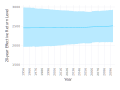

In [24]:
rmin = [c[i][1] for i in eachindex(c)]
rmax = [c[i][2] for i in eachindex(c)]
years = ipsl_data[1,:Years]
df = DataFrame(Year = years, r = vec(mean(r.value, dims=1)), rmin = rmin, rmax = rmax);

set_default_plot_size(12cm, 9cm)
plot(df, x=:Year, y=:r, ymin=:rmin, ymax=rmax, Geom.line, Geom.ribbon,
    Coord.cartesian(xmin=first(years), xmax=last(years)), Guide.xticks(ticks=first(years):10:last(years)),
    Guide.ylabel(string(T,"-year Effective Return Level")))

---
# 4. Sélection de modèle  <a name="selection"></a>

La fonction `dic`permet de calculer le critère d'information de déviation (DIC) :

In [25]:
res = dic.([fm1_std, fm2_std])

2-element Vector{Float64}:
 9363.083619050714
 9374.561607502399

<div class="alert alert-block alert-info">
    <b>Note :</b> On calcule le <code>dic</code> sur la version <b>standardisée</b> du modèle, c'est-à-dire celle qui a servi pour l'ajustement.

Un modèle est considéré meilleur qu’un autre lorsque la valeur du DIC correspondant est plus faible. On cherche  à déterminer le modèle avec la plus petite valeur de DIC avec la fonction `argmin(res)` qui retourne l'indice du plus petit élément de `res`.

In [26]:
argmin(res)

1

On obtient que le meilleur modèle est le **modèle 1**, c'est-à-dire le modèle stationnaire.

---
# 5. Enregistrement du modèle  <a name="enregistrement"></a>

Pour pouvoir utiliser les résultats de l'ajustement du modèle dans les parties suivantes de l'activité sans avoir à tout recalculer, il est utile d'enregistrer les résultats. La librairie Julia de base `Serialization` permet de sérialiser la structure `HierarchicalBayesEVA` et de l'exporter sous forme de fichier .txt qui pourra être désérialiser dans les parties suivantes.

In [27]:
using Serialization

io = open("3-Results/ModelSim.txt", "w");

serialize(io, fm1);

close(io);

<div class="alert alert-block alert-info">
<b>Note :</b> La <i>sérialisation</i> est le processus de conversion d'un objet en flux d'octets pour stocker l'objet ou le transmettre à la mémoire, une base de données ou un fichier. Son principal objectif est d'enregistrer l'état d'un objet afin de pouvoir le recréer si nécessaire. Le processus inverse est appelé <i>désérialisation</i>.